<a href="https://colab.research.google.com/github/AlexAlexeyuk/Alexander.Alexeyuk/blob/ready/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8_%D0%B8_%D0%B2%D1%8B%D0%B2%D0%BE%D0%B4%D1%8B_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Цель обучения моделей: 
* Построить модель, которая смогла бы минимизировать количество назначенных антибиотиков при нулевом уровне ложноотрицательных результатов
## Задачи:
* Построить наиболее эффективные модели машинного обучения для поставленной цели
* Произвести настройку параметров
* Оценить качество моделей и соотнести качество с поставленной целью
* Реализовать принцип решения задачи "обнуления" ложноотрицательных результатов путём стэкинга моделей, по аналогии с распространённым подходом в медицине
 -- консилиум, когда если даже один оценщик считает, что антибиотики показаны - определяем как показание к антибиотикам
го исхода.

## Импорт необходимых библиотек

In [14]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import mannwhitneyu,ttest_ind, kruskal,chisquare, pearsonr, spearmanr
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt 
!pip install colorama
from colorama import Fore, Back, Style 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
from statsmodels.formula.api import ols
import plotly.graph_objs as gobj
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")
import plotly.figure_factory as ff
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
import matplotlib as mpl
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from colorama import Fore, Back, Style 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
from statsmodels.formula.api import ols
import plotly.graph_objs as gobj
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
import plotly.figure_factory as ff
%matplotlib inline
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
!pip install catboost
from catboost import CatBoostClassifier
!pip install h2o
import h2o
h2o.init()
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2OIsolationForestEstimator
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators import H2OSupportVectorMachineEstimator
from h2o.grid.grid_search import H2OGridSearch




Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,12 mins 09 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_unknownUser_d8qu40
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.960 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [75]:
df = pd.read_csv('/content/covid_data.csv')
df = df.drop('Unnamed: 0', axis=1)

In [76]:
# разделяем набор данных на тренировочную, тестовую и валидационную части и нормализуем данные
X = df.drop('Ab_ind', axis=1)  
Y = df['Ab_ind']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, stratify = Y, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.20, stratify = Y_train, random_state = 42)
train = X_train.copy()
test = X_test.copy()
valid = X_val.copy()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
# т.к. есть определённые проблемы с переводом отскалированных данных в 
# H2O фрейм - данные переведены без скалирования, нормализация "прошита" в H2O
train = h2o.H2OFrame(train)
test = h2o.H2OFrame(test)
valid = h2o.H2OFrame(valid)
Y = h2o.H2OFrame(Y_train.reset_index())
V = h2o.H2OFrame(Y_val.reset_index())
T = h2o.H2OFrame(Y_test.reset_index())
train['target'] = Y['Ab_ind']
valid['target'] = V['Ab_ind']
test['target'] = T['Ab_ind']

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


## Машинное обучение в H2O

# GBM

In [17]:
predictors = train.col_names
predictors.remove('target')# определяем таргет

train['target'] = train['target'].asfactor() # опрелеляем таргет как фактор
valid['target'] = valid['target'].asfactor()#опрелеляем таргет как фактор
target  = 'target'
hyperparams_tune = {
    'max_depth' : list(range(2, 6, 1)),
    'sample_rate' : [x/100. for x in range(20,101)],
    'col_sample_rate' : [x/100. for x in range(20,101)],
    'min_split_improvement': [0, 1e-8, 1e-6, 1e-4]}

search_criteria_tune = {
    'strategy' : "RandomDiscrete",
    'max_runtime_secs' : 300,  ## лимит 5 минут 
    'max_models' : 15,  ## строим не более 15 моделей
    'stopping_rounds' : 5,
    'stopping_metric' : "AUCPR", # тестировал разные варианты, AUC оказался наиболее дееспособным
    'stopping_tolerance': 1e-3}
gbm_final_grid = H2OGradientBoostingEstimator(
    ## Используем много деревьев с ранней остановкой
    ntrees = 10000,
    
    learn_rate = 0.05,
    learn_rate_annealing = 0.99,
    ## каждые 10 деревьев - оценка
    score_tree_interval = 10,
    ## рандомное семя для воспроизводимости
    seed = 12345,
    ## Баланс "прошит" в модели, надо просто постаить "True"
    balance_classes = True,
    )
final_grid = H2OGridSearch(
    gbm_final_grid,
    hyper_params = hyperparams_tune,
    search_criteria = search_criteria_tune)
final_grid.train(x = predictors,
           y = target,
           training_frame = train,
           validation_frame = valid, 
           max_runtime_secs = 180)
sorted_gbm_grid = final_grid.get_grid(sort_by = 'aucpr')
best_gbm = sorted_gbm_grid.models[0]
best_gbm_perf_valid = best_gbm.model_performance(valid)
best_gbm_perf_test = best_gbm.model_performance(test)
params_list = []
for key, value in best_gbm.params.items():
    params_list.append(str(key)+" = "+str(value['actual']))
best_gbm_perf_test  # берем наилучшую модель 

#best_gbm_perf_valid.aucpr(), best_gbm_perf_test.aucpr(), 

gbm Grid Build progress: |████████████████████████████████████████████████| 100%

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.12211267175035008
RMSE: 0.34944623585088175
LogLoss: 0.38704327753297474
Mean Per-Class Error: 0.23741258741258742
AUC: 0.7853146853146853
AUCPR: 0.39118605378440025
Gini: 0.5706293706293706

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18090752210422364: 


,,0,1,Error,Rate
0,0,118.0,25.0,0.1748,(25.0/143.0)
1,1,9.0,21.0,0.3,(9.0/30.0)
2,Total,127.0,46.0,0.1965,(34.0/173.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.180908,0.552632,45.0
1,max f2,0.130678,0.635359,60.0
2,max f0point5,0.309308,0.492958,27.0
3,max accuracy,0.502583,0.832370,4.0
4,max precision,0.502583,0.600000,4.0
5,max recall,0.041540,1.000000,141.0
6,max specificity,0.670456,0.993007,0.0
7,max absolute_mcc,0.180908,0.450041,45.0
8,max min_per_class_accuracy,0.130678,0.734266,60.0
9,max mean_per_class_accuracy,0.180908,0.762587,45.0



Gains/Lift Table: Avg response rate: 17.34 %, avg score: 14.24 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011561,0.601493,2.883333,2.883333,0.500000,0.664068,0.500000,0.664068,0.033333,0.033333,188.333333,188.333333,0.026340
1,2,0.023121,0.540486,2.883333,2.883333,0.500000,0.574954,0.500000,0.619511,0.033333,0.066667,188.333333,188.333333,0.052681
2,3,0.034682,0.491436,2.883333,2.883333,0.500000,0.497815,0.500000,0.578946,0.033333,0.100000,188.333333,188.333333,0.079021
3,4,0.040462,0.473046,0.000000,2.471429,0.000000,0.482974,0.428571,0.565236,0.000000,0.100000,-100.000000,147.142857,0.072028
4,5,0.052023,0.448530,0.000000,1.922222,0.000000,0.460157,0.333333,0.541885,0.000000,0.100000,-100.000000,92.222222,0.058042
5,6,0.104046,0.366347,2.562963,2.242593,0.444444,0.397552,0.388889,0.469719,0.133333,0.233333,156.296296,124.259259,0.156410
6,7,0.150289,0.309526,3.604167,2.661538,0.625000,0.348955,0.461538,0.432561,0.166667,0.400000,260.416667,166.153846,0.302098
7,8,0.202312,0.237784,2.562963,2.636190,0.444444,0.276633,0.457143,0.392465,0.133333,0.533333,156.296296,163.619048,0.400466
8,9,0.300578,0.152166,1.696078,2.328846,0.294118,0.186730,0.403846,0.325205,0.166667,0.700000,69.607843,132.884615,0.483217
9,10,0.398844,0.107616,0.678431,1.922222,0.117647,0.131149,0.333333,0.277394,0.066667,0.766667,-32.156863,92.222222,0.444988


Что ж, результат нельзя сказать, что впечатляющий: 9 ложноотрицательных значений

In [18]:
h2o_GM_model_prediction_test = final_grid[0].predict(test)
h2o_GM_model_prediction_test = h2o.h2o.as_list(h2o_GM_model_prediction_test, 
                                               use_pandas=True)

gbm prediction progress: |████████████████████████████████████████████████| 100%


# XGBoost

In [19]:
hyperparams_tune = {
    'max_depth' : list(range(2, 6, 1)),
    'sample_rate' : [x/100. for x in range(20,101)],
    'col_sample_rate' : [x/100. for x in range(20,101)],
    'min_split_improvement': [0, 1e-8, 1e-6, 1e-4]}

search_criteria_tune = {
    'strategy' : "RandomDiscrete",
    'max_runtime_secs' : 300,  
    'max_models' : 15,  
    'stopping_rounds' : 5,
    'stopping_metric' : "AUCPR",
    'stopping_tolerance': 1e-3}
xgb_final_grid = H2OGradientBoostingEstimator(
    ntrees = 10000,
    learn_rate = 0.05,
    learn_rate_annealing = 0.99,
    score_tree_interval = 10,
    seed = 12345,
    balance_classes = True
    )
final_grid = H2OGridSearch(
    xgb_final_grid,
    hyper_params = hyperparams_tune,
    search_criteria = search_criteria_tune)
final_grid.train(x = predictors,
           y = target,
           training_frame = train,
           validation_frame = valid, 
           max_runtime_secs = 180) # can override setting in search_criteria_tune
sorted_xgb_grid = final_grid.get_grid(sort_by = 'aucpr')
best_xgb = sorted_xgb_grid.models[0]
best_xgb_perf_valid = best_xgb.model_performance(valid)
best_xgb_perf_test = best_xgb.model_performance(test)
params_list = []
for key, value in best_xgb.params.items():
    params_list.append(str(key)+" = "+str(value['actual']))
best_xgb_perf_test


gbm Grid Build progress: |████████████████████████████████████████████████| 100%

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.12241880117913823
RMSE: 0.3498839824558109
LogLoss: 0.3873826826129558
Mean Per-Class Error: 0.24790209790209794
AUC: 0.7885780885780885
AUCPR: 0.41438083800576675
Gini: 0.5771561771561771

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18303626930372227: 


,,0,1,Error,Rate
0,0,119.0,24.0,0.1678,(24.0/143.0)
1,1,10.0,20.0,0.3333,(10.0/30.0)
2,Total,129.0,44.0,0.1965,(34.0/173.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.183036,0.540541,43.0
1,max f2,0.084689,0.637255,83.0
2,max f0point5,0.289091,0.507246,26.0
3,max accuracy,0.642122,0.832370,0.0
4,max precision,0.642122,1.000000,0.0
5,max recall,0.037727,1.000000,144.0
6,max specificity,0.642122,1.000000,0.0
7,max absolute_mcc,0.183036,0.433675,43.0
8,max min_per_class_accuracy,0.147857,0.733333,54.0
9,max mean_per_class_accuracy,0.175362,0.752098,48.0



Gains/Lift Table: Avg response rate: 17.34 %, avg score: 14.34 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011561,0.591963,2.883333,2.883333,0.500000,0.640278,0.500000,0.640278,0.033333,0.033333,188.333333,188.333333,0.026340
1,2,0.023121,0.548069,2.883333,2.883333,0.500000,0.573734,0.500000,0.607006,0.033333,0.066667,188.333333,188.333333,0.052681
2,3,0.034682,0.504409,0.000000,1.922222,0.000000,0.510192,0.333333,0.574735,0.000000,0.066667,-100.000000,92.222222,0.038695
3,4,0.040462,0.496260,5.766667,2.471429,1.000000,0.502475,0.428571,0.564412,0.033333,0.100000,476.666667,147.142857,0.072028
4,5,0.052023,0.461820,0.000000,1.922222,0.000000,0.480928,0.333333,0.545860,0.000000,0.100000,-100.000000,92.222222,0.058042
5,6,0.104046,0.391578,2.562963,2.242593,0.444444,0.415228,0.388889,0.480544,0.133333,0.233333,156.296296,124.259259,0.156410
6,7,0.150289,0.295385,4.325000,2.883333,0.750000,0.361059,0.500000,0.443779,0.200000,0.433333,332.500000,188.333333,0.342424
7,8,0.202312,0.226116,1.281481,2.471429,0.222222,0.255013,0.428571,0.395239,0.066667,0.500000,28.148148,147.142857,0.360140
8,9,0.300578,0.162863,2.035294,2.328846,0.352941,0.187115,0.403846,0.327199,0.200000,0.700000,103.529412,132.884615,0.483217
9,10,0.398844,0.109910,0.678431,1.922222,0.117647,0.133411,0.333333,0.279454,0.066667,0.766667,-32.156863,92.222222,0.444988


10 ложноотрицательных значений, ещё хуже, чем GBM

In [27]:
h2o_XGB_model_prediction_test = final_grid[0].predict(test)
h2o_XGB_model_prediction_test = h2o.h2o.as_list(h2o_XGB_model_prediction_test, use_pandas=True)

gbm prediction progress: |████████████████████████████████████████████████| 100%


# RandomForest

In [28]:
 hyperparams_tune = {
    'max_depth' : list(range(2, 6, 1)),
    'sample_rate' : [x/100. for x in range(20,101)],
    'min_split_improvement': [0, 1e-8, 1e-6, 1e-4]}

search_criteria_tune = {
    'strategy' : "RandomDiscrete",
    'max_runtime_secs' : 300,
    'max_models' : 15,  
    'stopping_rounds' : 5,
    'stopping_metric' : "AUCPR",
    'stopping_tolerance': 1e-3}
drf_final_grid = H2ORandomForestEstimator(
    ntrees = 10000,
    score_tree_interval = 10,
    seed = 12345,
    balance_classes = True)
final_grid = H2OGridSearch(
    drf_final_grid,
    hyper_params = hyperparams_tune,
    search_criteria = search_criteria_tune)
final_grid.train(x = predictors,
           y = target,
           training_frame = train,
           validation_frame = valid, 
           max_runtime_secs = 180) # can override setting in search_criteria_tune
sorted_drf_grid = final_grid.get_grid(sort_by = 'aucpr')
best_drf = sorted_drf_grid.models[0]
best_drf_perf_valid = best_drf.model_performance(valid)
best_drf_perf_test = best_drf.model_performance(test)
params_list = []
for key, value in best_drf.params.items():
    params_list.append(str(key)+" = "+str(value['actual']))
best_drf_perf_test#best_drf_perf_valid.aucpr(), best_drf_perf_test.aucpr(), params_list

drf Grid Build progress: |████████████████████████████████████████████████| 100%

ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.1290782168720009
RMSE: 0.3592745703107874
LogLoss: 0.41249158822753146
Mean Per-Class Error: 0.2783216783216783
AUC: 0.761072261072261
AUCPR: 0.4101726235749167
Gini: 0.522144522144522

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2296655460071298: 


,,0,1,Error,Rate
0,0,129.0,14.0,0.0979,(14.0/143.0)
1,1,15.0,15.0,0.5,(15.0/30.0)
2,Total,144.0,29.0,0.1676,(29.0/173.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.229666,0.508475,28.0
1,max f2,0.131592,0.615385,74.0
2,max f0point5,0.229666,0.513699,28.0
3,max accuracy,0.262925,0.843931,16.0
4,max precision,0.382343,1.000000,0.0
5,max recall,0.092801,1.000000,150.0
6,max specificity,0.382343,1.000000,0.0
7,max absolute_mcc,0.229666,0.407549,28.0
8,max min_per_class_accuracy,0.137188,0.685315,65.0
9,max mean_per_class_accuracy,0.131592,0.721678,74.0



Gains/Lift Table: Avg response rate: 17.34 %, avg score: 15.04 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011561,0.356657,2.883333,2.883333,0.500000,0.374688,0.500000,0.374688,0.033333,0.033333,188.333333,188.333333,0.026340
1,2,0.023121,0.342071,2.883333,2.883333,0.500000,0.347969,0.500000,0.361329,0.033333,0.066667,188.333333,188.333333,0.052681
2,3,0.034682,0.333402,0.000000,1.922222,0.000000,0.337809,0.333333,0.353489,0.000000,0.066667,-100.000000,92.222222,0.038695
3,4,0.040462,0.320100,0.000000,1.647619,0.000000,0.324323,0.285714,0.349322,0.000000,0.066667,-100.000000,64.761905,0.031702
4,5,0.052023,0.291321,2.883333,1.922222,0.500000,0.308878,0.333333,0.340335,0.033333,0.100000,188.333333,92.222222,0.058042
5,6,0.104046,0.256055,4.485185,3.203704,0.777778,0.269858,0.555556,0.305096,0.233333,0.333333,348.518519,220.370370,0.277389
6,7,0.150289,0.238459,1.441667,2.661538,0.250000,0.245710,0.461538,0.286824,0.066667,0.400000,44.166667,166.153846,0.302098
7,8,0.202312,0.204634,2.562963,2.636190,0.444444,0.216756,0.457143,0.268806,0.133333,0.533333,156.296296,163.619048,0.400466
8,9,0.300578,0.166284,0.678431,1.996154,0.117647,0.180661,0.346154,0.239990,0.066667,0.600000,-32.156863,99.615385,0.362238
9,10,0.398844,0.133958,1.356863,1.838647,0.235294,0.149697,0.318841,0.217744,0.133333,0.733333,35.686275,83.864734,0.404662


15 ложноотрицательных предсказаний случайного леса

In [29]:
h2o_RF_model_prediction_test = final_grid[0].predict(test)
h2o_RF_model_prediction_test = h2o.h2o.as_list(h2o_RF_model_prediction_test, use_pandas=True)

drf prediction progress: |████████████████████████████████████████████████| 100%


## Определение других оценщиков ( SVM, LogRegr, CatBoost, LGB)

In [38]:
def all_estimators(X_train, X_test, Y_train, Y_test):
  """Функция - все оценщики

  На вход подаются уже отскалированные данные: тренировочная и тестовая  подвыборки.

  На выходе - словарь с предсказаниями на тестовой выборке
  
  """
  # подбор параметров происходил при помощи GridSearch с кросс-валидацией
  log_reg = LogisticRegression(C=5, 
                             tol=0.001,  
                             solver = 'sag', 
                             class_weight = {0:.99, 1:16},
                             max_iter=200,
                             random_state=123,
                             n_jobs=-1
                             )
  log_reg.fit(X_train, Y_train)
  log_reg_pred_test = log_reg.predict(X_test)
  # подбор параметров происходил при помощи GridSearch с кросс-валидацией
  sv_clf = SVC(C=10, 
             gamma=0.001, 
             kernel='rbf', 
             class_weight={0:1, 1:11},
             random_state=123
            )
  sv_clf.fit(X_train, Y_train)
  sv_clf_pred_test = sv_clf.predict(X_test)


  model = CatBoostClassifier(
    eval_metric='F1',
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
    class_weights = {0:1, 1:66}
    )
  model.fit(
    X_train, Y_train,
    
    verbose=False,
    plot=True
    )
  cat_pred_test = model.predict(data=X_test)


  # подбор параметров осуществлялся при помощи библиотеки FLAML
  lg=LGBMClassifier(colsample_bytree=0.9901173566841761, learning_rate=1.0,
               max_bin=511, min_child_weight=0.9842705371351147,
               n_estimators=19, num_leaves=8, objective='binary',
               reg_alpha=4.5697209030862906e-06,
               reg_lambda=0.19094909947197827, class_weight = {0:.02, 1:3.8}
    )
  lg.fit(X_train,Y_train)
  ypred_test = lg.predict(X_test)


  all_pred_test = {'Logistic': log_reg_pred_test, "SVM": sv_clf_pred_test,
                   "CatBoost": cat_pred_test, "LGBM": ypred_test,
                   "Actual_labels": Y_test
                   }

  return all_pred_test

In [39]:
test_matrix = all_estimators(X_train=X_train, X_test=X_test, Y_train=Y_train, Y_test=Y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [40]:
# формируем матрицу предсказаний моделей
test_matrix = pd.DataFrame(test_matrix)

In [41]:
# обновляем индексы,чтобы не было  проблем с дальнейшей склейкой столбцов
test_matrix = test_matrix.reset_index()

In [42]:
#добавляем оценщиков к общим матрицам оценок
test_matrix['h2o_XGB'] = h2o_XGB_model_prediction_test['predict']
test_matrix['h2o_GBM'] = h2o_GM_model_prediction_test['predict']
test_matrix['h2o_RF'] = h2o_RF_model_prediction_test['predict']
test_matrix = test_matrix.drop(["Actual_labels", 'index'], axis=1)
Y_test = Y_test.reset_index()
test_matrix['Actual_labels'] = Y_test["Ab_ind"]

In [43]:
pd.options.display.max_rows = 999
test_matrix[test_matrix['Actual_labels'] == 1]

,Logistic,SVM,CatBoost,LGBM,h2o_XGB,h2o_GBM,h2o_RF,Actual_labels
0,1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,1
9,0,0,1,0,1,1,0,1
19,1,1,1,1,1,1,0,1
21,1,1,1,1,1,1,0,1
22,1,1,1,1,1,1,1,1
26,1,1,1,1,1,1,1,1
27,0,1,1,1,0,0,0,1
29,1,1,1,1,1,1,1,1
38,1,1,1,1,1,1,1,1


Следует обратить внимание, что есть запись, где ни одна модель не определила показание к АБ-терапии, что плохо, учитывая цель - 0 ложноотрицательных значений

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  """Функция матрица несоответствий.

  На вход - реальные таргеты и предстказанные
  На выходе матрица несоответствий
  """
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Legitimate Transactions Detected (True Negatives):  35
Legitimate Transactions Incorrectly Detected (False Positives):  108
Fraudulent Transactions Missed (False Negatives):  1
Fraudulent Transactions Detected (True Positives):  29
Total Fraudulent Transactions:  30


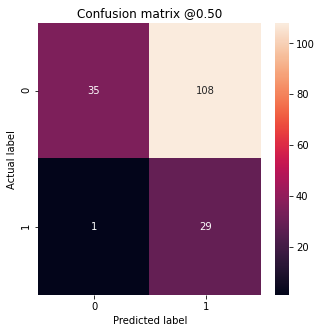

In [52]:
test_matrix['STACK'] = (test_matrix['Logistic'] + 
                        test_matrix['SVM'] +
                        test_matrix['CatBoost'] +
                        test_matrix['LGBM'] +
                        test_matrix['h2o_XGB'] +
                        test_matrix['h2o_GBM'] +
                        test_matrix['h2o_RF'] )
# Определил признак "Стэк", если он больше или равен 1 = 1, иначе = 0
test_matrix['STACK'] = test_matrix['STACK'].map(lambda 
                                                x: x + 1 - x 
                                                if x >= 1
                                                else 0)
plot_cm(test_matrix['Actual_labels'], test_matrix['STACK'])



---


## Глубокое обучение

In [77]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
cleaned_df = df.copy()
val_features = np.array(X_val) # определяем все параметры и лейблы 
test_features = np.array(X_test)# как массивы, для более удобной работы
train_labels = np.array(Y_train)
val_labels = np.array(Y_val)
test_labels = np.array(Y_test)
train_features = np.array(X_train)
bool_train_labels = train_labels != 0
train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (552,)
Validation labels shape: (138,)
Test labels shape: (173,)
Training features shape: (552, 24)
Validation features shape: (138, 24)
Test features shape: (173, 24)


In [78]:
METRICS = [ # определяем все метрики
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
# определяем структуру нейронной сети
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu', # активатор - релу
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', # валидационная площадь под РОК-кривой как критерий ранней остановки
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)
model = make_model()
model.summary()
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16)                400       
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 417
Trainable params: 417
Non-trainable params: 0
_________________________________________________________________
Loss: 0.7167


In [79]:
neg, pos = np.bincount(df['Ab_ind'])
initial_bias = np.log([pos/neg])
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

Loss: 0.5205


In [80]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [81]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

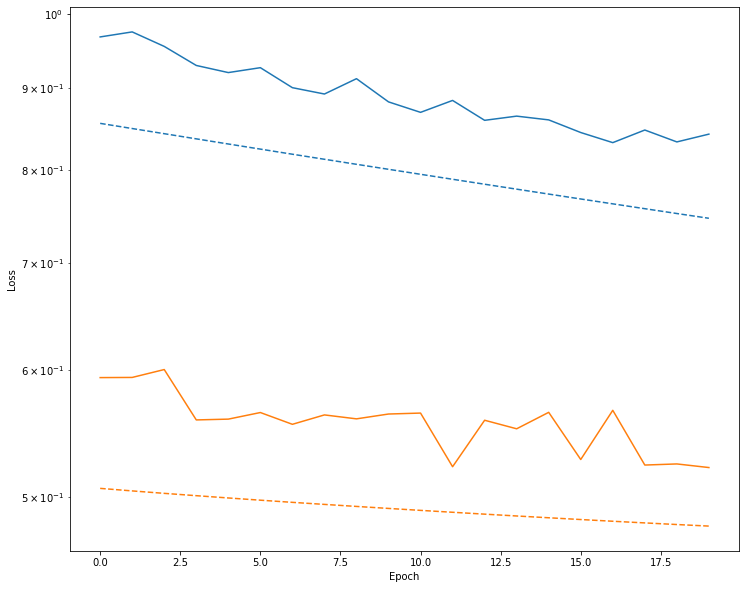

In [82]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')


plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [83]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.5449 - tp: 9.0000 - fp: 45.0000 - tn: 527.0000 - fn: 109.0000 - accuracy: 0.7768 - precision: 0.1667 - recall: 0.0763 - auc: 0.5200 - val_loss: 0.5067 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 114.0000 - val_fn: 24.0000 - val_accuracy: 0.8261 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4465
Epoch 2/100
1/1 [==============================] - 0s 63ms/step - loss: 0.5793 - tp: 8.0000 - fp: 50.0000 - tn: 408.0000 - fn: 86.0000 - accuracy: 0.7536 - precision: 0.1379 - recall: 0.0851 - auc: 0.4752 - val_loss: 0.5049 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 114.0000 - val_fn: 24.0000 - val_accuracy: 0.8261 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4479
Epoch 3/100
1/1 [==============================] - 0s 62ms/step - loss: 0.5552 - tp: 9.0000 - fp: 44.0000 - tn: 414.0000 - fn: 85.0000 - accuracy: 0.7663 - precision: 0.1698 - recall: 0.0957 - auc: 0.4887 - 

In [84]:
def plot_metrics(history):
  # определяем построение графиков обучения
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [85]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

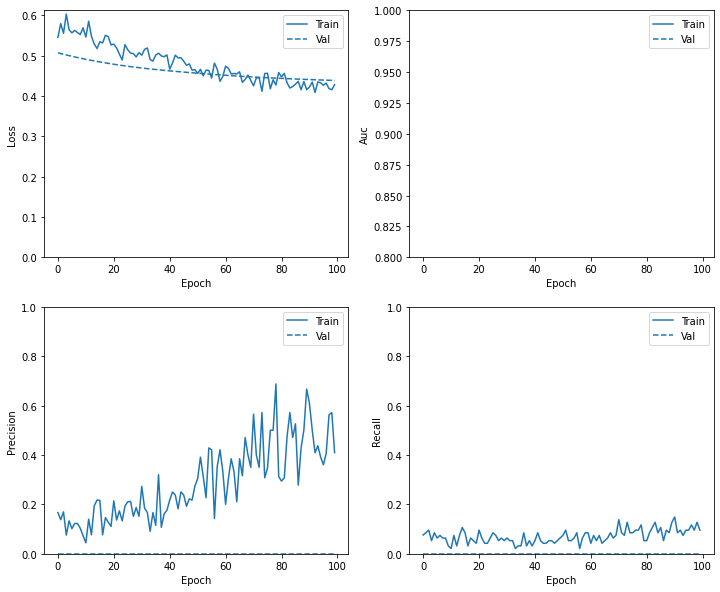

In [86]:
plot_metrics(baseline_history)

In [87]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.3931953012943268
tp :  3.0
fp :  0.0
tn :  143.0
fn :  27.0
accuracy :  0.8439306616783142
precision :  1.0
recall :  0.10000000149011612
auc :  0.757109522819519

Legitimate Transactions Detected (True Negatives):  143
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  27
Fraudulent Transactions Detected (True Positives):  3
Total Fraudulent Transactions:  30


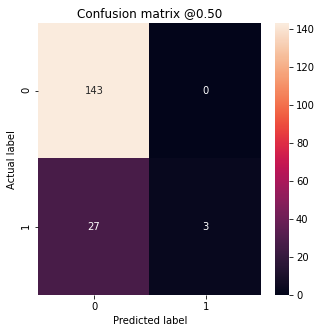

In [88]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

Итого, первое приближение. Т.к. имеет место дисбаланс в таргете, стандартные настройки работают не так как хотелось бы

In [89]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

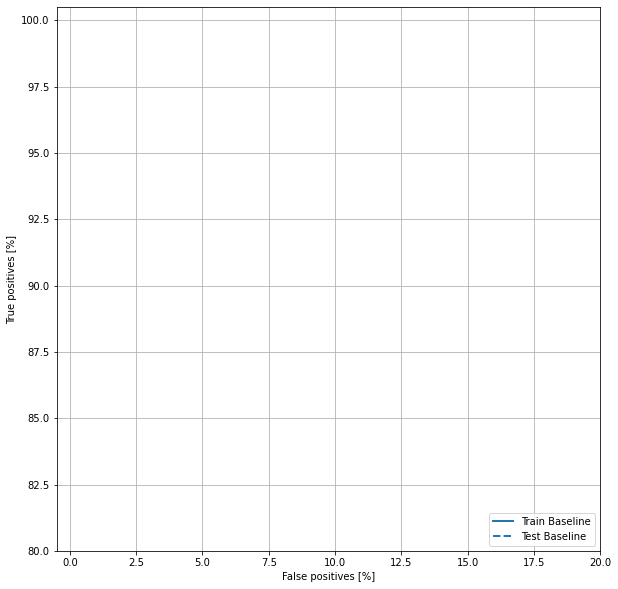

In [90]:
import sklearn
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [91]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # определил веса. Экспериментировал с разными вариантами, но
    # сначительно снизить количество ложнонеративных значений менее 6 не удалось
    class_weight=class_weight) 

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 6.3088 - tp: 10.0000 - fp: 68.0000 - tn: 533.0000 - fn: 114.0000 - accuracy: 0.7490 - precision: 0.1282 - recall: 0.0806 - auc: 0.5087 - val_loss: 0.5082 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 114.0000 - val_fn: 24.0000 - val_accuracy: 0.8261 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4437
Epoch 2/100
1/1 [==============================] - 0s 70ms/step - loss: 6.0234 - tp: 11.0000 - fp: 50.0000 - tn: 408.0000 - fn: 83.0000 - accuracy: 0.7591 - precision: 0.1803 - recall: 0.1170 - auc: 0.4896 - val_loss: 0.5079 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 114.0000 - val_fn: 24.0000 - val_accuracy: 0.8261 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4454
Epoch 3/100
1/1 [==============================] - 0s 70ms/step - loss: 6.1915 - tp: 5.0000 - fp: 50.0000 - tn: 408.0000 - fn: 89.0000 - accuracy: 0.7482 - precision: 0.0909 - recall: 0.0532 - auc: 0.4575 

loss :  0.6189079284667969
tp :  21.0
fp :  52.0
tn :  91.0
fn :  9.0
accuracy :  0.647398829460144
precision :  0.2876712381839752
recall :  0.699999988079071
auc :  0.771794855594635

Legitimate Transactions Detected (True Negatives):  91
Legitimate Transactions Incorrectly Detected (False Positives):  52
Fraudulent Transactions Missed (False Negatives):  9
Fraudulent Transactions Detected (True Positives):  21
Total Fraudulent Transactions:  30


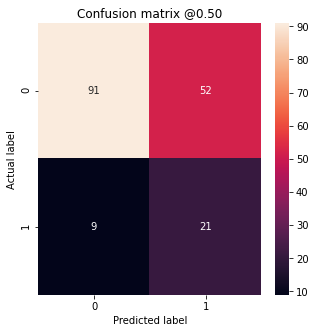

In [92]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

Модель с весами классов даёт неплохой результат, но всё ещё очень большая ошибка - 9

In [130]:
# чтобы попытаться улучшить модель, попробуем использовать бустрап-подход, а именно:
# уже существующие признаки случайным образом перенаберём, тем самым, позволим
# "лучше" нейронной сети понять закономерности взаимосвязи таргетного значения с признаками
bool_train_labels = train_labels != 0
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]
pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))
res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)
order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]
resampled_features.shape

(916, 24)

In [131]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [132]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], 
                                                         weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [133]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.8656 - tp: 627.0000 - fp: 698.0000 - tn: 428.0000 - fn: 468.0000 - accuracy: 0.4750 - precision: 0.4732 - recall: 0.5726 - auc: 0.4479 - val_loss: 0.8574 - val_tp: 16.0000 - val_fp: 90.0000 - val_tn: 24.0000 - val_fn: 8.0000 - val_accuracy: 0.2899 - val_precision: 0.1509 - val_recall: 0.6667 - val_auc: 0.4443
Epoch 2/100
1/1 [==============================] - 0s 77ms/step - loss: 0.8316 - tp: 616.0000 - fp: 618.0000 - tn: 390.0000 - fn: 424.0000 - accuracy: 0.4912 - precision: 0.4992 - recall: 0.5923 - auc: 0.4670 - val_loss: 0.8531 - val_tp: 16.0000 - val_fp: 90.0000 - val_tn: 24.0000 - val_fn: 8.0000 - val_accuracy: 0.2899 - val_precision: 0.1509 - val_recall: 0.6667 - val_auc: 0.4466
Epoch 3/100
1/1 [==============================] - 0s 77ms/step - loss: 0.8436 - tp: 581.0000 - fp: 648.0000 - tn: 409.0000 - fn: 410.0000 - accuracy: 0.4834 - precision: 0.4727 - recall: 0.5863 - auc: 0.4663 - val_loss: 0.8488 - va

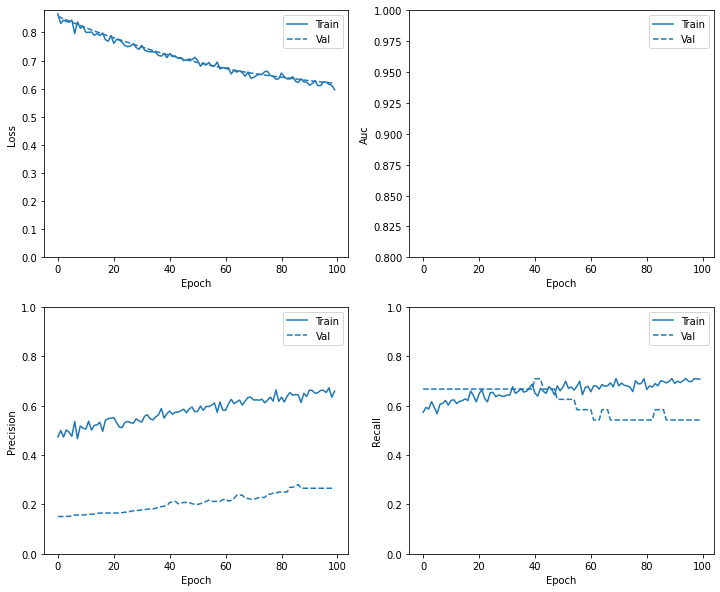

In [134]:
plot_metrics(resampled_history)

Epoch 1/1000
20/20 [==============================] - 4s 77ms/step - loss: 3.1489 - tp: 7373.1905 - fp: 7329.6190 - tn: 3976.1429 - fn: 3924.5238 - accuracy: 0.4975 - precision: 0.4968 - recall: 0.6382 - auc: 0.4750 - val_loss: 0.8594 - val_tp: 19.0000 - val_fp: 95.0000 - val_tn: 19.0000 - val_fn: 5.0000 - val_accuracy: 0.2754 - val_precision: 0.1667 - val_recall: 0.7917 - val_auc: 0.5104
Epoch 2/1000
20/20 [==============================] - 1s 29ms/step - loss: 2.8028 - tp: 8857.4762 - fp: 7724.3333 - tn: 3574.1905 - fn: 2274.4762 - accuracy: 0.5525 - precision: 0.5341 - recall: 0.7889 - auc: 0.5448 - val_loss: 0.8556 - val_tp: 20.0000 - val_fp: 94.0000 - val_tn: 20.0000 - val_fn: 4.0000 - val_accuracy: 0.2899 - val_precision: 0.1754 - val_recall: 0.8333 - val_auc: 0.5970
Epoch 3/1000
20/20 [==============================] - 1s 28ms/step - loss: 2.6099 - tp: 9613.4762 - fp: 7760.7619 - tn: 3379.4286 - fn: 1676.8095 - accuracy: 0.5794 - precision: 0.5540 - recall: 0.8494 - auc: 0.6032 

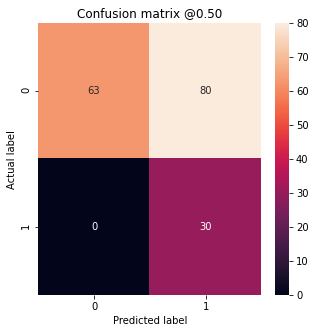

In [164]:
tf.random.set_seed(1234)
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds),
    class_weight={0:2.6, 1:5.5} # хотя и бустрап выборка в какой-то мере
    # сбалансирована, т.к. мы хотим нулевой уровень ложноотр.результата - 
    #определяем веса классов
    )

train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(np.array(X_test), batch_size=BATCH_SIZE)
valid_predictions_resampled = resampled_model.predict(np.array(X_val), batch_size=BATCH_SIZE)
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

Нейронные сети - лидер обучения - 100% чувствительность) и отличный recall (специфичность)

In [192]:
test_predictions_resampled = resampled_model.predict(np.array(X_test), 
                                                     batch_size=BATCH_SIZE)

In [193]:
test_predictions_resampled = list(map(lambda x: 
                                      np.round(x +.5) if x >=.5  # определение порога "перехода" к лейблу 1
                                      else x, test_predictions_resampled))

In [194]:
# определил предсказанное значение как признак
test_matrix['Neural_net'] = test_predictions_resampled 

## Стекинг моделей

Legitimate Transactions Detected (True Negatives):  30
Legitimate Transactions Incorrectly Detected (False Positives):  113
Fraudulent Transactions Missed (False Negatives):  0
Fraudulent Transactions Detected (True Positives):  30
Total Fraudulent Transactions:  30


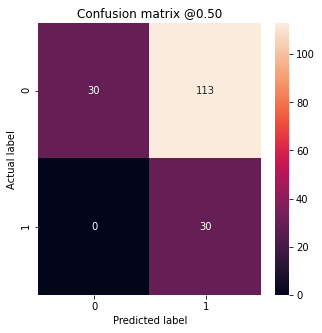

In [195]:
test_matrix['STACK'] = (test_matrix['Logistic'] + 
                        test_matrix['SVM'] +
                        test_matrix['CatBoost'] +
                        test_matrix['LGBM'] +
                        test_matrix['h2o_XGB'] +
                        test_matrix['h2o_GBM'] +
                        test_matrix['h2o_RF'] +
                        test_matrix['Neural_net'])
# Определил признак "Стэк", если он больше или равен 1 = 1, иначе = 0
test_matrix['STACK'] = test_matrix['STACK'].map(lambda 
                                                x: x + 1 - x 
                                                if x >= 1
                                                else 0)
plot_cm(Y_test, test_matrix['STACK'])

In [196]:
test_matrix[test_matrix['Actual_labels'] == 1]

,Logistic,SVM,CatBoost,LGBM,h2o_XGB,h2o_GBM,h2o_RF,Actual_labels,STACK,Neural_net
0,1,1,1,1,1,1,1,1,[1.0],[1.0]
2,0,0,0,0,0,0,0,1,[1.0],[1.0]
9,0,0,1,0,1,1,0,1,[1.0],[1.0]
19,1,1,1,1,1,1,0,1,[1.0],[1.0]
21,1,1,1,1,1,1,0,1,[1.0],[1.0]
22,1,1,1,1,1,1,1,1,[1.0],[1.0]
26,1,1,1,1,1,1,1,1,[1.0],[1.0]
27,0,1,1,1,0,0,0,1,[1.0],[1.0]
29,1,1,1,1,1,1,1,1,[1.0],[1.0]
38,1,1,1,1,1,1,1,1,[1.0],[1.0]


## Итог:


*   Целевой показатель ложнонегативное предсказание равен 0, что являлось принципиальным условием. Достичь удалось на бустрап-нейронной сети и стекинге
*   Лучшая модель способна снизить назначение антибиотиков с 95 % ( изначально) до 63 %, что очень неплохо.
* Поставленная цель достигнута при помощи глубокого обучения, чтобы улучшить модель необходимо больше данных




